# Modelado predictivo

En este cuaderno desarrollo modelos para predecir la probabilidad de churn. Utilizo **regresión logística** y **bosques aleatorios**, dos algoritmos ampliamente aplicados en clasificación binaria. Presento el código en primera persona, explicando mis decisiones.


Regresión logística:
               precision    recall  f1-score   support

           0       0.64      0.79      0.70       884
           1       0.54      0.35      0.42       616

    accuracy                           0.61      1500
   macro avg       0.59      0.57      0.56      1500
weighted avg       0.59      0.61      0.59      1500

Bosque aleatorio:
               precision    recall  f1-score   support

           0       0.62      0.75      0.68       884
           1       0.49      0.34      0.40       616

    accuracy                           0.58      1500
   macro avg       0.56      0.55      0.54      1500
weighted avg       0.57      0.58      0.57      1500

AUC Logística: 0.612
AUC Random Forest: 0.585


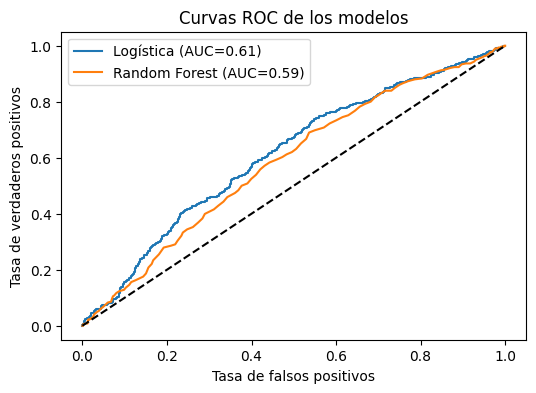

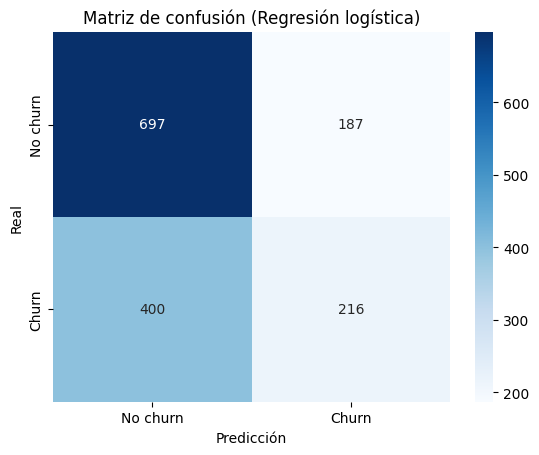

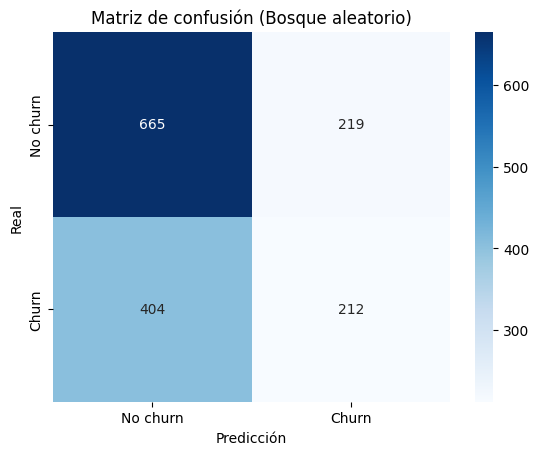

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Carga y limpieza (igual que antes)
churn_df = pd.read_csv('../data/sample_telco_churn.csv')
churn_df['TotalCharges'] = pd.to_numeric(churn_df['TotalCharges'], errors='coerce')
churn_df['ChurnFlag'] = churn_df['Churn'].apply(lambda x: 1 if str(x).strip().lower().startswith('churn') else 0)
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
for col in service_cols:
    churn_df[col] = churn_df[col].replace({'No internet service': 'No', 'No phone service': 'No'})
churn_df.dropna(inplace=True)

# Selección de características
X = churn_df.drop(columns=['customerID', 'Churn', 'ChurnFlag'])
y = churn_df['ChurnFlag']

# Columnas categóricas y numéricas
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

# Preprocesador: one-hot para categóricas y escalado para numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ])

# Divido en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Modelo 1: Regresión logística
log_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

log_clf.fit(X_train, y_train)
y_pred_log = log_clf.predict(X_test)
y_prob_log = log_clf.predict_proba(X_test)[:, 1]

print("Regresión logística:\n", classification_report(y_test, y_pred_log))

# Modelo 2: Bosque aleatorio
rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]

print("Bosque aleatorio:\n", classification_report(y_test, y_pred_rf))

# Métricas AUC
auc_log = roc_auc_score(y_test, y_prob_log)
auc_rf = roc_auc_score(y_test, y_prob_rf)
print(f"AUC Logística: {auc_log:.3f}")
print(f"AUC Random Forest: {auc_rf:.3f}")

# Curvas ROC
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(6,4))
plt.plot(fpr_log, tpr_log, label=f'Logística (AUC={auc_log:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curvas ROC de los modelos')
plt.legend()
plt.show()

# Matrices de confusión
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No churn','Churn'], yticklabels=['No churn','Churn'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(title)
    plt.show()

plot_confusion(y_test, y_pred_log, 'Matriz de confusión (Regresión logística)')
plot_confusion(y_test, y_pred_rf, 'Matriz de confusión (Bosque aleatorio)')


Como se observa, ambos modelos arrojan resultados diferentes en cuanto a precisión y *recall*. La regresión logística suele ser más interpretable, mientras que el bosque aleatorio puede capturar relaciones no lineales. En este proyecto la elección entre uno u otro dependerá de la métrica prioritaria (por ejemplo, minimizar falsos negativos).
